# Assignment 1

In this assignment you will be implementing some components of neural networks in numpy from scratch (all your code should be vectorized; and you shouldn’t use any library besides numpy and matplotlib). Base meta classes for the various activations, layers and optimizers are provided; all of your implementations must be classes that inherit from the appropriate base meta class. **When implementing backwards passes, please include in Markdown an analytical derivation of the backwards pass.**

# Step 1: Fully-connected neural networks


## General comments

In this step you will implement all the components you need to construct and train a fully-connected neural network:  the forward and backwards passes for various activations and types of layers, a loss (baked into the SoftMax class), a class to hold the stacked layers together and a couple of optimizers. 

The forward pass is relatively straightforward: each layer outputs an array that the following layer takes as its input. The backwards pass, on the other hand, is a bit more complicated and to be able to complete it, you need to both have the incoming gradient and the original input to each layer, represented by the variable "original_input" in our code. The gradient returned by the backward() call of any given layer is then used as input for the backward() call of the layer immediately preceding it.

In [641]:
!pip install batchup

In [642]:
import matplotlib.pyplot as plt
import numpy as np
from batchup import data_source

# 1. 

Implement the forwards and backwards passes for the following activations: a) Sigmoid, $\sigma(x) = \frac{1}{1+e^{-x}}$; b) Tanh, tthat returns the tangent hyperbolic function of its input,  $y = tanh(x)$. The ReLU class is done for you as an example.

**Note that defining the __ call __ function allows you to avoid calling the forward function directly, i.e. instead of calling ReLU.forward(x), you should call ReLU(x) instead (for example).**

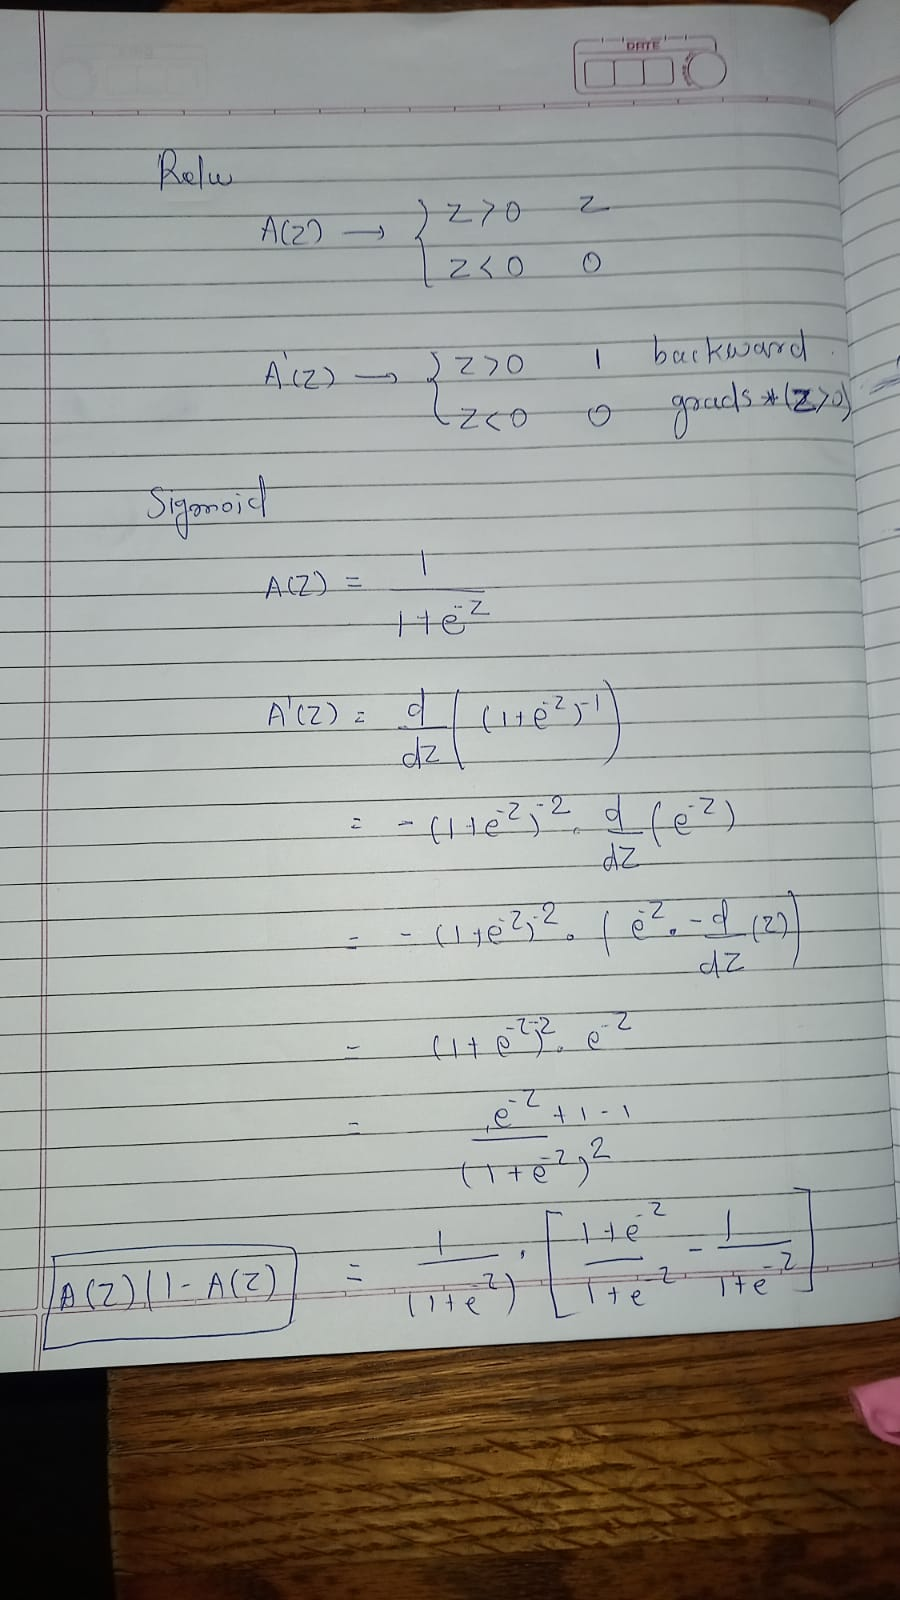

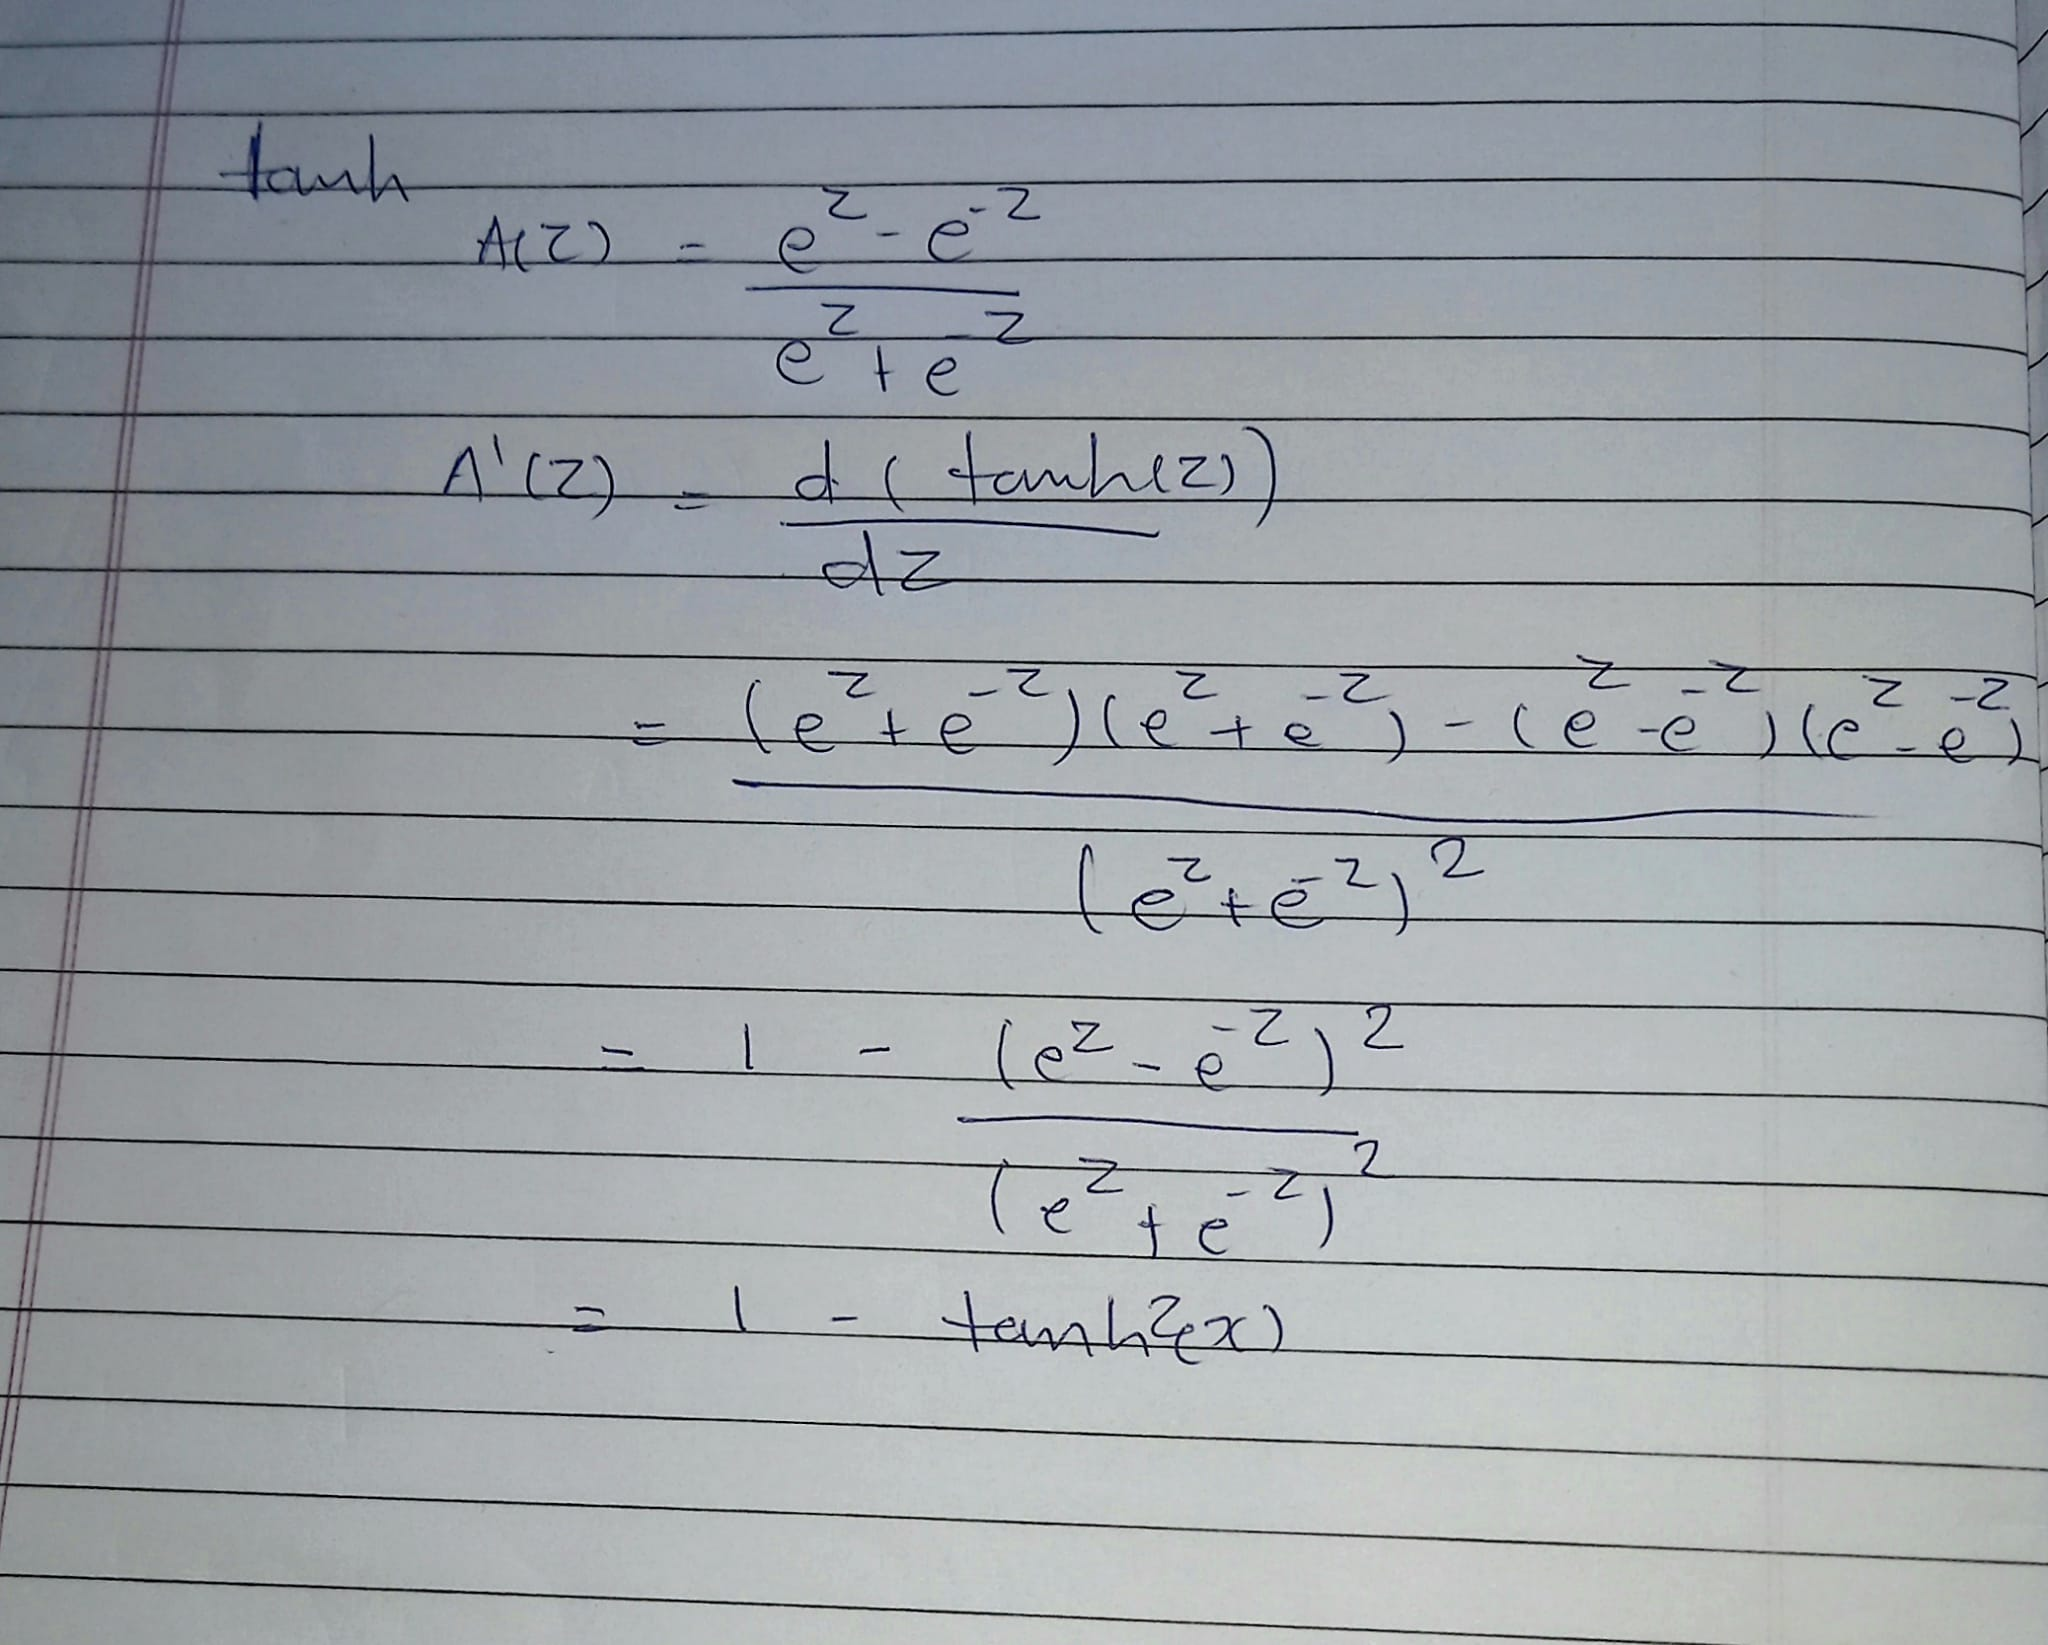

In [643]:
import abc

# Abstract base class for all activation classes
class Activations(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self,x):
        return

    @abc.abstractmethod
    def backward(self, grad):
        return
    
class ReLU(Activations):    
    def forward(self,x):
        #print("Shape of input in ReLU forward", x.shape)
        # return result
        self.x = x
        return np.maximum(0,x)
    
    def backward(self, grad):
        #print("Shape of grad in ReLU backward", grad.shape)
        #this assumes that the original input to this layer has been saved somewhere else
        return grad*(self.x>0)
    
    def __call__(self,x,mode=None):
        return self.forward(x)

class Sigmoid(Activations):
    def forward(self,x):
        #print("Shape of input in Sigmoid forward", x.shape)
        # return result
        self.x = x
        self.out = 1 / (1 + np.exp(-x))
        return self.out
    
    def backward(self, grad):
        #print("Shape of grad in Sigmoid backward", grad.shape)
        return grad*(self.out)*(1-self.out)
        
    def __call__(self,x,mode=None):
        return self.forward(x)
        
class Tanh(Activations):
    def forward(self,x):
        #print("Shape of input in Tanh forward", x.shape)
        # return result
        self.x = x
        self.out = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x));
        return self.out

    def backward(self, grad):
        #print("Shape of grad in Tanh backward", grad.shape)
        return grad*(1 - self.out**2)
        
    def __call__(self,x,mode=None):
        return self.forward(x)

# 2.

Implement an activation (“SoftmaxCrossLoss”) that has two modes of operation: a) if a target, $y_{true}$, is provided then it operates in the same manner as the Pytorch CrossEntropyLoss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (basically the usual softmax activation plus a cross-entropy loss); b) if no target $y_{true}$ is provided, then the forward pass just returns the softmax of the input (no backwards pass needs to be implemented for this mode): for a vector $\mathbf{x}=(x_1,x_2, \cdots, x_n)$, Softmax$(\mathbf{x})_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$ (when using batches this operation should be done for each vector in the batch). 

While implementing softmax shift your input by using shifted_x = x - np.max(x, axis=1, keepdims=True). This does not affect the result of the softmax operation and improves numerical stability.

Note that "mode" is included in this class's function calls just to keep a unified interface for use in the fully-connected neural network.

Resource: https://deepnotes.io/softmax-crossentropy

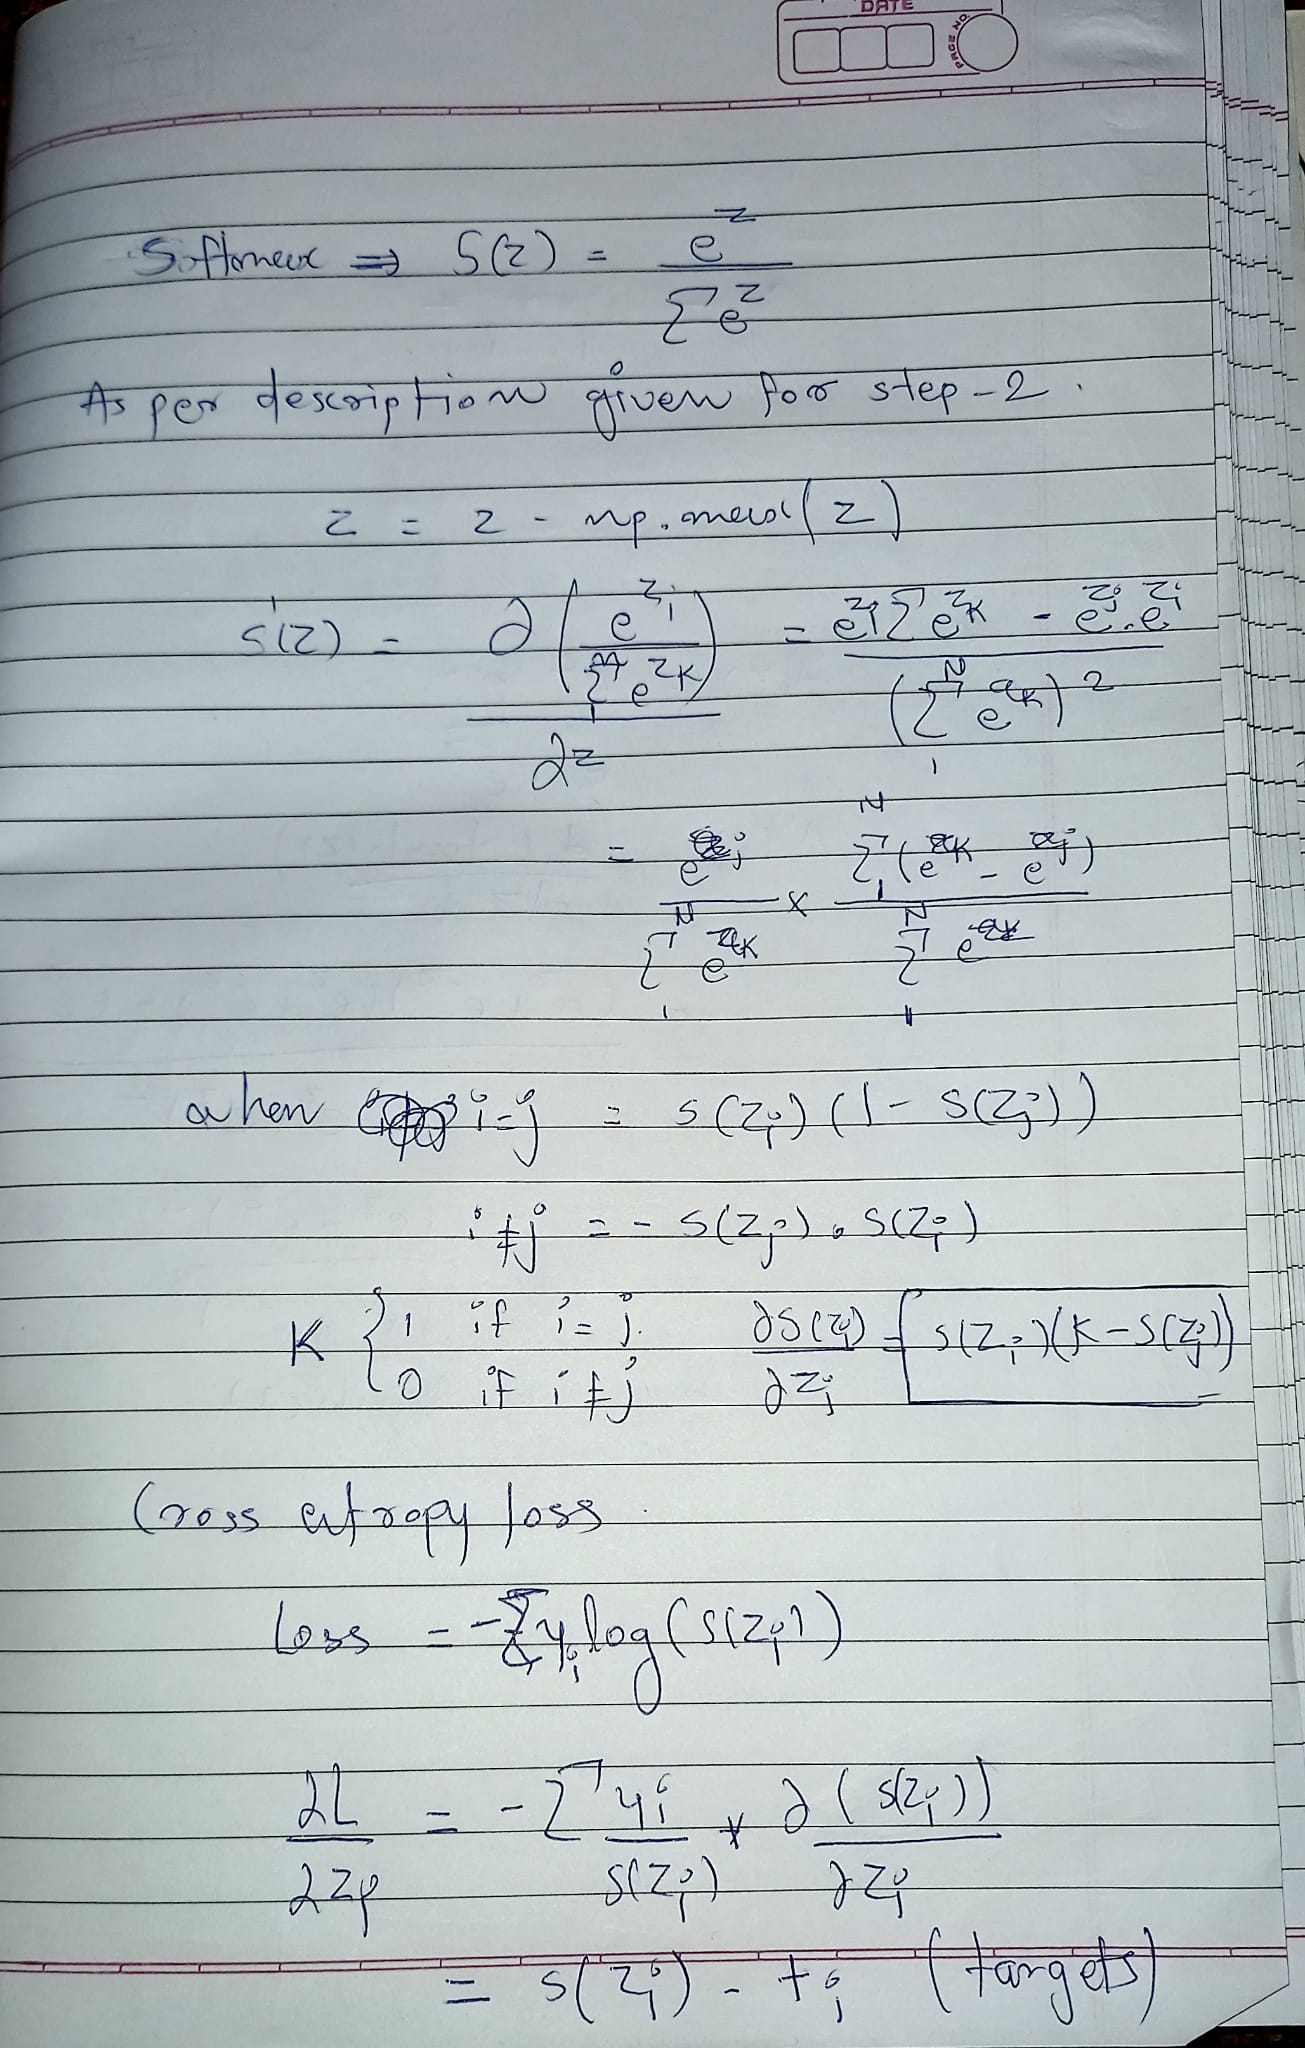

In [644]:
class SoftMaxCrossLoss(Activations):
    def __init__(self):
        self.probs = None
        self.y = None

    def softmax(self, x):
          #print("Shape of input in Softmax", x.shape)
          exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
          return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self,x, y=None):
        #y being none should make this return simply a softmax activation: we are in testing mode
        #y is not none, you should return the cross-entropy loss using the softmax activations
        #print("Shape of x,y in SoftmaxCrossLoss forward", x.shape, y.shape)
        self.y = y
        self.probs = self.softmax(x)
        if y is not None:
          self.log_l = -np.log(self.probs)
          loss = np.sum(np.multiply(y, self.log_l)) / self.y.size
          return loss
        else:
          #softmax activation
          return self.probs
        
    def backward(self, grad):
        # if grad != None:
        #    print("Shape of grad in SoftmaxCrossLoss backward", grad.shape)
        # else:
        #    print("Backward started")
        #backward pass for softmax + crossEntropy
        temp_probs = self.probs.copy()
        grad = temp_probs - self.y
        return grad
    
    def __call__(self,x,y=None, mode=None):
        return self.forward(x,y)

# 3.

Implement three layers (with both forward and backwards passes): a) an AffineLayer (with input dimension input_dim and hidden units hidden_dim), whose forward pass returns $Y=Xw^T + b$, where w and b are the weights and bias respectively; b) an Inverted Dropout (https://machinelearning.wtf/terms/inverted-dropout/) layer that keeps weights with probability p; c) **Only for 6505 students**: a BatchNorm layer.

Note that the gradients of the parameters of each layer should be kept inside their respective layers. Dropout and Batchnorm behave different based on whether we are in "train" or "test" mode.

Resources:



Affine Layer

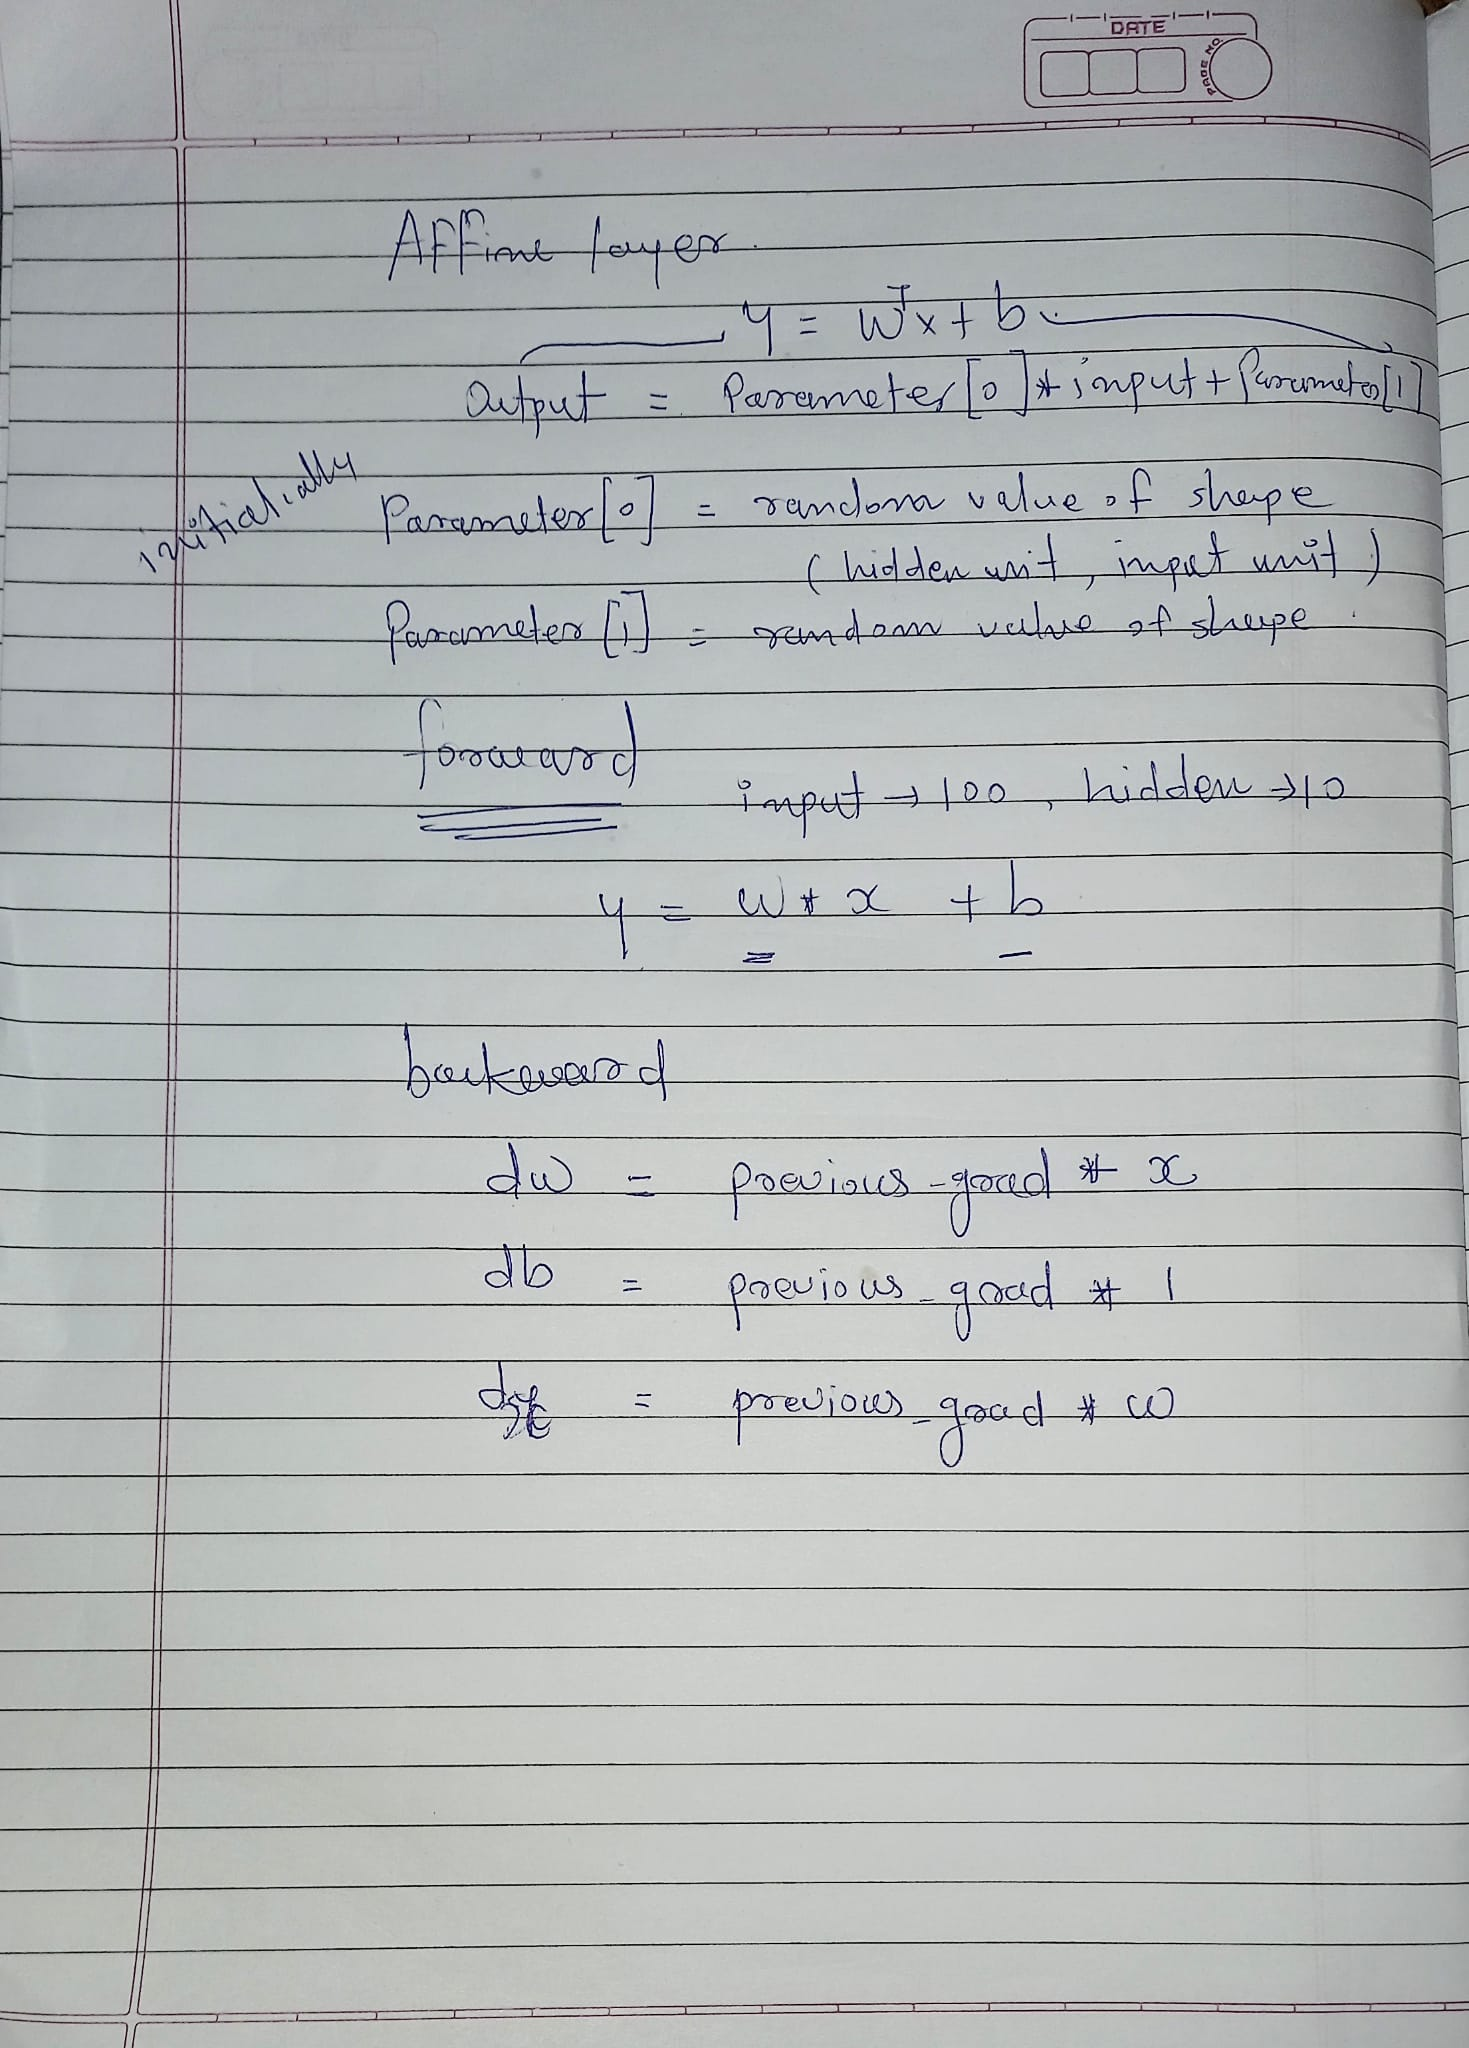

Dropout Partial Derivative (Source: [link text](https://deepnotes.io/dropout))

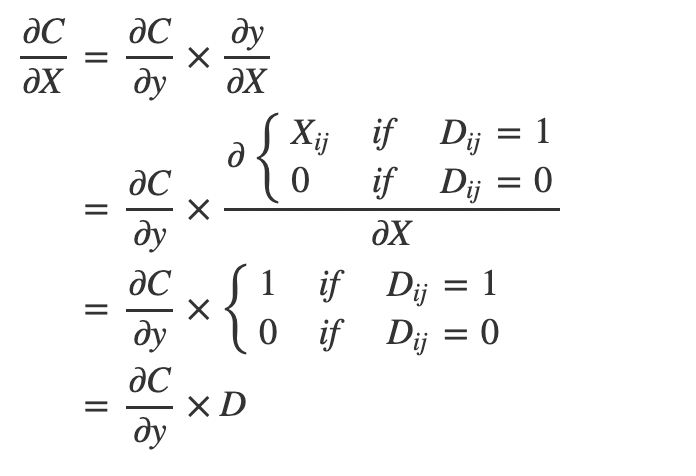

In [645]:
class Layers(metaclass=abc.ABCMeta):
      @abc.abstractmethod
      def forward(self,x):
          return 

      @abc.abstractmethod
      def backward(self, grad):
          return
        
class AffineLayer(Layers):
      def __init__(self, input_dim, hidden_units):
          ran = np.sqrt(1/input_dim)
          #Initializing the weights and bias, in that order
          self.parameters = [np.random.uniform(-ran,ran,(hidden_units,input_dim)), np.random.uniform(-ran,ran,hidden_units)]
          self.grads = [np.zeros_like(self.parameters[0]),np.zeros_like(self.parameters[1])]
          self.change = [np.zeros_like(self.parameters[0]),np.zeros_like(self.parameters[1])]

      def forward(self,x):
          #print("Shape of x in Affine forward", x.shape)
          # y = wx + b  
          self.X = x
          #X.T (784,20)
          #w (200,784)
          #w@x.T (200,20)
          #b (200,)
          self.out = (self.parameters[0] @ self.X.T).T +self.parameters[1]

          return self.out
          
      def backward(self, grad):
          #print("Shape of grad in Affine backward", grad.shape)
          #dw*grad => X*grad
          self.grads[0] =  self.X.T @ grad
          #db*grad => 1*grad
          self.grads[1] =  np.sum(grad, axis = 0)
          #return gradient with respect to the original input to this layer
          #dX*grad => W*grad
          grad_x = self.parameters[0].T @ grad.T
          return grad_x.T
          
      def getLayerParameters(self):
          return (self.parameters, self.grads, self.change)
      

      def __call__(self,x,mode=None):
          return self.forward(x)
        
class BatchNorm(Layers):
    def __init__(self, dim):
        #
        #Initialize the parameters
        #
        self.gamma = np.ones((1, dim))
        self.beta = np.zeros((1, dim))
        self.grads = []
    
    def forward(self,x):
        #
        #Fill in
        #In Batch Normalization - we do take all x(i) from all the samples available in a Batch and calculate the Normalized inputs for next layers
        # 
        x_transpose = x.T
        self.parameters = [] 
        mean_x = x_transpose.mean(axis=0)
        variance_x = x.var(axis=0)
        normalized_x = (x_transpose-mean_x)/variance_x[:,None]
        #I'm not able to implement the below formula in vectorized format
        #batch_normalized_x = self.gamma*normalized_x + self.beta
        return x

    def backward(self, grad):
        #
        #Fill in
        #
        #return gradient with respect to the original input to this layer
        return grad
        

class Dropout(Layers):
      def __init__(self,p):
          self.prob = p
          self.mask = None

      def forward(self,x,mode):
          #print("Dropout input dimension:", x.shape)
          #scaled the dropout with keep prob (1-prob)
          self.mask = np.random.binomial(1,self.prob,size=x.shape) / (1-self.prob)
          output = np.multiply(x, self.mask)
          return output

      def backward(self, grad):
          #print("Dropout grad dimension:", grad.shape)
          #backward pass
          if grad.shape[0] == self.mask.shape[0]: 
             grad_x = np.multiply(grad, self.mask)
          else:
             grad_x = np.multiply(grad, self.mask.T)
             
          return grad_x

      def __call__(self,x,mode="test"):
          return self.forward(x,mode)

# 4.

Implement a fully connected neural network that takes as input some user-defined layers and has both forward and backward passes (you should use the forward and backward passes from the previously defined layers).

In [671]:
class FCNN1:
    def __init__(self, layers):
        self.layers = layers
        self.original_inputs = []
        
    def forward(self,x,y = None, mode ='test'):
        #Start by adding the input to the original_inputs array that keeps the original_input to each
        #layer in order.
        self.original_inputs = [x.copy()]
        #foraward pass [AffineLayer(28*28, 200), ReLU(), dropout(), AffineLayer(200,10), ReLU(), SoftmaxCrossEntropy()]

        self.original_inputs.append(self.layers[0].forward(x))
        self.original_inputs.append(self.layers[1].forward(self.original_inputs[-1]))
        self.original_inputs.append(self.layers[2].forward(self.original_inputs[-1], "train"))
        self.original_inputs.append(self.layers[3].forward(self.original_inputs[-1]))
        self.original_inputs.append(self.layers[4].forward(self.original_inputs[-1]))
        self.original_inputs.append(self.layers[5].forward(self.original_inputs[-1], "train"))
        self.original_inputs.append(self.layers[6].forward(self.original_inputs[-1], y))
        return self.original_inputs[-1]
    
    def backward(self): 
        #backward pass [SoftmaxCrossEntropy(), ReLU(), AffineLayer(200,10), dropout(), ReLU(), AffineLayer(28*28, 200)]

        grad = self.layers[-1].backward(None)
        grad = self.layers[-2].backward(grad)
        grad = self.layers[-3].backward(grad)
        grad = self.layers[-4].backward(grad)
        grad = self.layers[-5].backward(grad)
        grad = self.layers[-6].backward(grad)
        
        #This should be the grad w.r.t input only
        return grad
            
        
    def __call__(self,x, y = None, mode='test'):
        return self.forward(x,y,mode)

# 5.

Implement the following optimizers: a) stochastic gradient descent with momentum; b) **Only for 6505 students**: the Adam optimizer (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html). These optimizers should take as input a layer and update their parameters according to the gradients stored in the layers.

Note that Adam requires you to keep a track of the running means of gradients. A python dictionary to organize this might prove useful.

Resources:
<p><a>https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d</a></p>
<p><a>https://www.youtube.com/watch?v=k8fTYJPd3_I</a></p>
<p><a>https://machinelearningmastery.com/adam-optimization-from-scratch/</a></p>

In [672]:
#SGD with Momentum - Done
#Adam - Work in Progress 
class Optimizer(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def step(self,layer):
        return 

class SGD(Optimizer):
      def __init__(self, learning_rate, momentum):
        self.learning_rate = learning_rate
        self.momentum = momentum

      def step(self, layers):
          for layer in layers:
              params, grads, change = layer.getLayerParameters()
              m0 = (self.momentum*change[0])
              m1 = (self.momentum*change[1])
              d0 = (self.learning_rate*grads[0]) 
              d1 = (self.learning_rate*grads[1])
              
              if(m0.shape[1] == d0.shape[1]):
                #calculating the change and updating the w / paramete[0]
                change[0] = np.add(m0, d0)
                params[0] = params[0] - change[0]
                
                #calculating the change and updating the w / paramete[1]
                change[1] = np.add(m1, d1)
                params[1] = params[1] - change[1]
              else:
                #calculating the change and updating the w / paramete[0]
                change[0] = np.add(m0, d0.T)
                params[0] = params[0] - change[0]
                
                #calculating the change and updating the w / paramete[1]
                change[1] = np.add(m1, d1.T)
                params[1] = params[1] - change[1]
                
class Adam(Optimizer):
      def __init__(self):
          #Initialize the parameters you need.
          pass
          
      def step(self, layer):
          #
          #Fill in
          #
          pass

# 6.

Test out several fully connected architectures on the reduced MNIST dataset provided. Feed the dataset to your network in batches and experiment with the batch size. 
<br/><br/>
a) Experiment with the batch size. Does the batch size impact performance?
<p>ANS: Yes, changing the batch size is impacting the performance. I  have noticed that if I use smaller batch sizes like 10/20 it makes the training loss with time more jittery and I have obsered 100/200 is a good batch size</p>
<br/><br/>
b) Do you do better with two or three layers? Experiment with the hidden units in each layers.
<p>ANS: It has shown some improvements but it's not significant enough, the reason for that could be I haven't implemented the BatchNorm for regularization</p>
<br/><br/>
**c) Does adding more layers continually improve your results? **
<br/><br/>
**d) Does Dropout help?**
<p>ANS: Dropout plays a significant role in learning in earlier experient, I have avoided using the dropout layers and the results are very bad.</p>
<br/>
<br/>
**e) What can you say about the difficulty of training as you add layers?**
<p>ANS: 1) the time of execution, adding more layers is increating the training time a lot.
2) </p>
<br/>
<br/>
f) **Only for 6505 students**: Does Batchnorm improve results? 
<br><br>
g) **Only for 6505 students**: Try using the Adam optimizer. Do you converge more quickly? Do you get better results? 
<br><br>



**Download train.npz and test.npz from the Assignment 1 Files folder on teams. The data contains several thousand images represented by arrays of shape (28,28); before feeding it to your network you should flatten them so that each image has shape (784,).**

In [673]:
train_data = np.load("/content/sample_data/train.npz")['arr_0']
train_targets = np.load("/content/sample_data/train.npz")['arr_1']

In [674]:
#Resource Link
#https://batchup.readthedocs.io/en/latest/user/basic_batch_iter.html
def train1(layers, optimization_layer, learning_rate, momentum, batch_size, epochs):
    model = FCNN1(layers)
    optimizer = SGD(learning_rate = learning_rate, momentum = momentum)
    losses = []
    for _ in range(epochs):
      for (batch_X, batch_y) in ds.batch_iterator(batch_size=batch_size, shuffle=np.random.RandomState(352)):
          x = np.array([data.flatten() for data in batch_X])
          y = np.eye(10)[batch_y]
          current_loss = model.forward(x, y, mode ="train")
          losses.append(current_loss)
          model.backward()
          optimizer.step(optimization_layer)
    
    return losses

In [675]:
def visualize_loss(losees):
  plt.figure(figsize=(20,10))
  plt.plot(range(len(losses)), losses)
  plt.title("Training loss with time")
  plt.show()

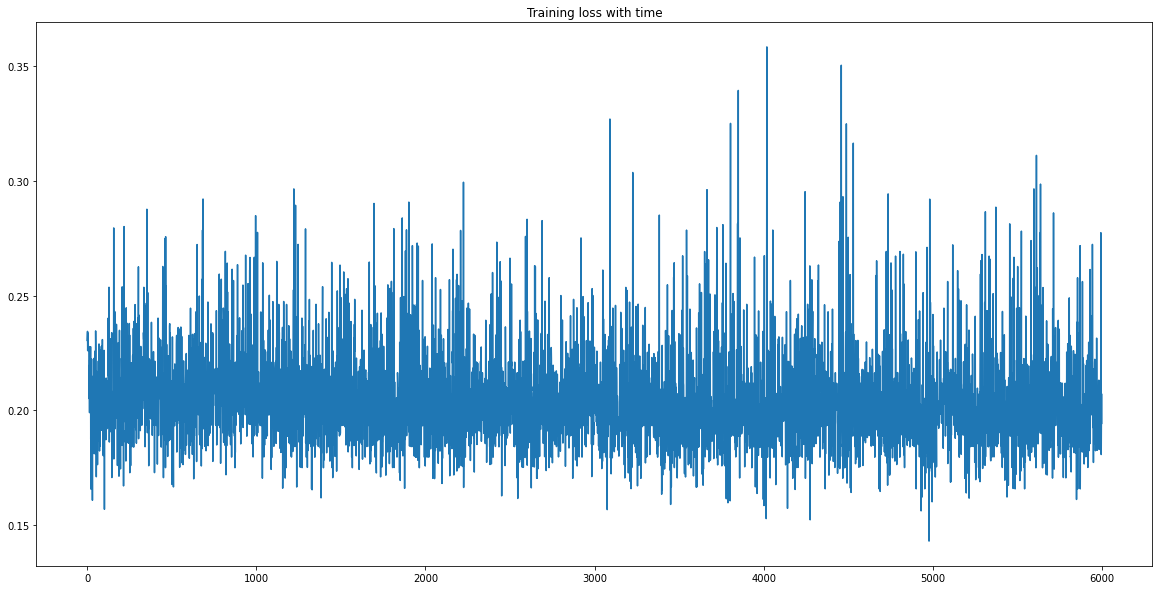

In [676]:
ds = data_source.ArrayDataSource([train_data, train_targets])

layers = [AffineLayer(784, 200), ReLU(), Dropout(0.5), AffineLayer(200,10), ReLU(), Dropout(0.5), SoftMaxCrossLoss()]
optimization_layer = [layers[0], layers[3]]

losses = train1(layers, optimization_layer, 0.001, 0.99, 50, 5)
visualize_loss(losses)

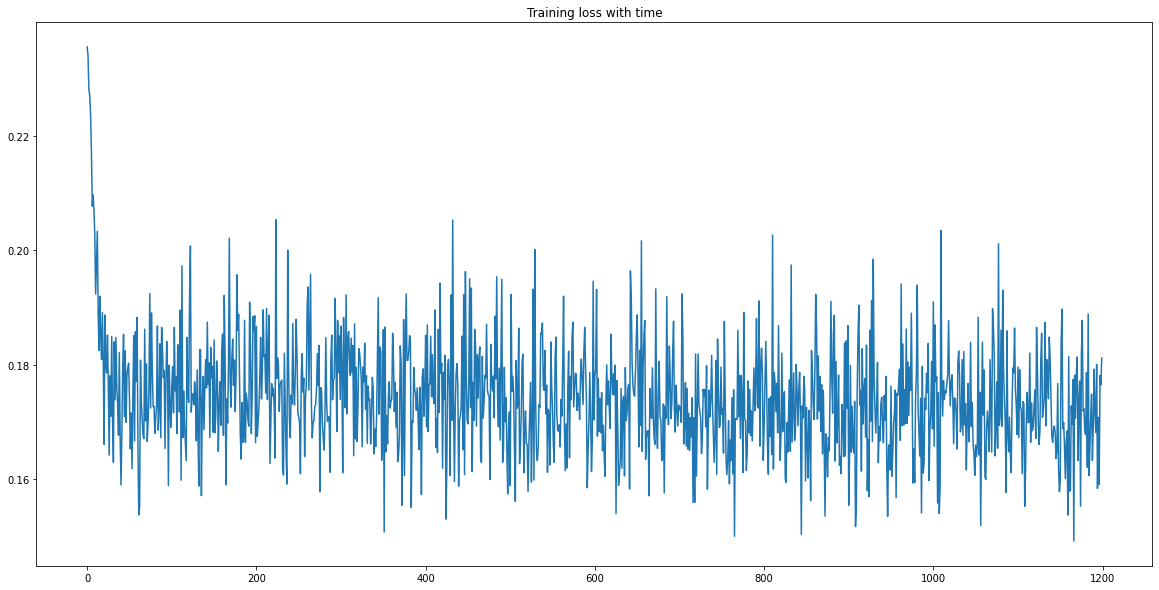

In [696]:
ds = data_source.ArrayDataSource([train_data, train_targets])

layers = [AffineLayer(784, 500), ReLU(), Dropout(0.5), AffineLayer(500,10), ReLU(), Dropout(0.6), SoftMaxCrossLoss()]
optimization_layer = [layers[0], layers[3]]

losses = train1(layers, optimization_layer, 0.0001, 0.99, 250, 5)
visualize_loss(losses)

**Make NN Deeper**

In [681]:
class FCNN2:
    def __init__(self, layers):
        self.layers = layers
        self.original_inputs = []
        
    def forward(self,x,y = None, mode ='test'):
        #Start by adding the input to the original_inputs array that keeps the original_input to each
        #layer in order.
        self.original_inputs = [x.copy()]
        #foraward pass [AffineLayer(28*28, 200), ReLU(), dropout(), AffineLayer(200,10), ReLU(), SoftmaxCrossEntropy()]

        self.original_inputs.append(self.layers[0].forward(x))
        self.original_inputs.append(self.layers[1].forward(self.original_inputs[-1]))
        self.original_inputs.append(self.layers[2].forward(self.original_inputs[-1], "train"))
        self.original_inputs.append(self.layers[3].forward(self.original_inputs[-1]))
        self.original_inputs.append(self.layers[4].forward(self.original_inputs[-1]))
        self.original_inputs.append(self.layers[5].forward(self.original_inputs[-1], "train"))
        self.original_inputs.append(self.layers[6].forward(self.original_inputs[-1]))
        self.original_inputs.append(self.layers[7].forward(self.original_inputs[-1]))
        self.original_inputs.append(self.layers[8].forward(self.original_inputs[-1], "train"))
        self.original_inputs.append(self.layers[9].forward(self.original_inputs[-1], y))
        return self.original_inputs[-1]
    
    def backward(self): 
        #backward pass [SoftmaxCrossEntropy(), ReLU(), AffineLayer(200,10), dropout(), ReLU(), AffineLayer(28*28, 200)]

        grad = self.layers[-1].backward(None)
        grad = self.layers[-2].backward(grad)
        grad = self.layers[-3].backward(grad)
        grad = self.layers[-4].backward(grad)
        grad = self.layers[-5].backward(grad)
        grad = self.layers[-6].backward(grad)
        grad = self.layers[-7].backward(grad)
        grad = self.layers[-8].backward(grad)
        grad = self.layers[-9].backward(grad)
        grad = self.layers[-10].backward(grad)
        
        #This should be the grad w.r.t input only
        return grad
            
        
    def __call__(self,x, y = None, mode='test'):
        return self.forward(x,y,mode)

In [682]:
#Resource Link
#https://batchup.readthedocs.io/en/latest/user/basic_batch_iter.html
def train2(layers, optimization_layer, learning_rate, momentum, batch_size, epochs):
    model = FCNN2(layers)
    optimizer = SGD(learning_rate = learning_rate, momentum = momentum)
    losses = []
    for _ in range(epochs):
      for (batch_X, batch_y) in ds.batch_iterator(batch_size=batch_size, shuffle=np.random.RandomState(352)):
          x = np.array([data.flatten() for data in batch_X])
          y = np.eye(10)[batch_y]
          current_loss = model.forward(x, y, mode ="train")
          losses.append(current_loss)
          model.backward()
          optimizer.step(optimization_layer)
    
    return losses

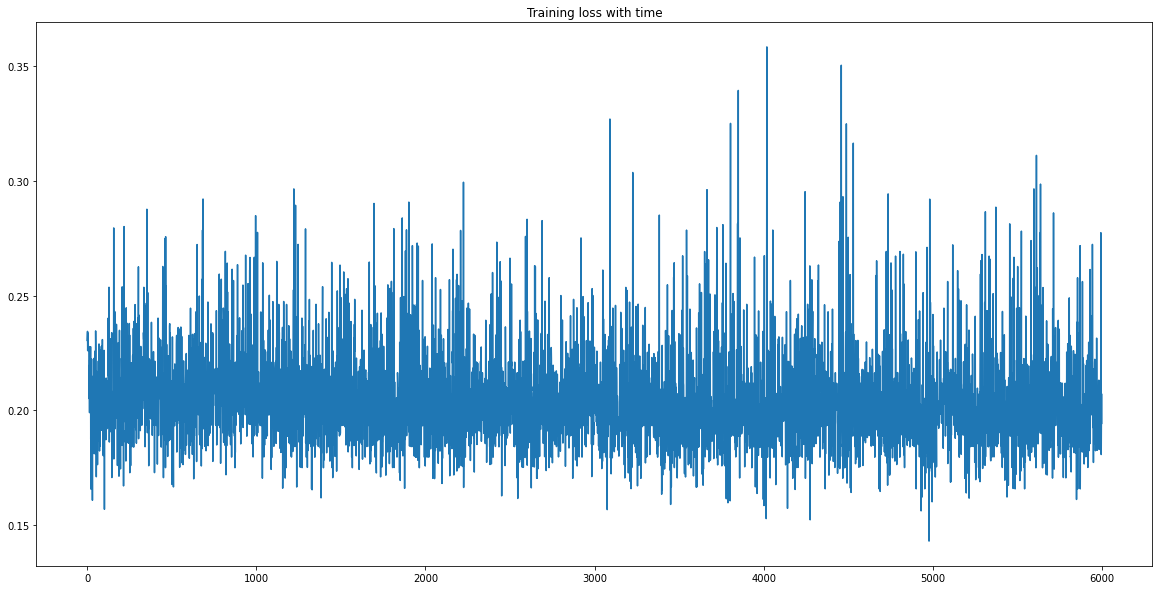

In [692]:
ds = data_source.ArrayDataSource([train_data, train_targets])

layers = [AffineLayer(784, 500), ReLU(), Dropout(0.7), AffineLayer(500,200), ReLU(), Dropout(0.7), AffineLayer(200, 10), ReLU(), Dropout(0.5), SoftMaxCrossLoss()]
optimization_layer = [layers[0], layers[3], layers[6]]

losses1 = train2(layers, optimization_layer, 0.001, 0.9, 100, 5)
visualize_loss(losses1)

In [693]:
layers = [AffineLayer(784, 400), ReLU(), Dropout(0.7), AffineLayer(400,200), ReLU(), Dropout(0.7), AffineLayer(200, 10), ReLU(), Dropout(0.5), SoftMaxCrossLoss()]
optimization_layer = [layers[0], layers[3], layers[6]]

losses2 = train2(layers, optimization_layer, 0.0001, 0.9, 100, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


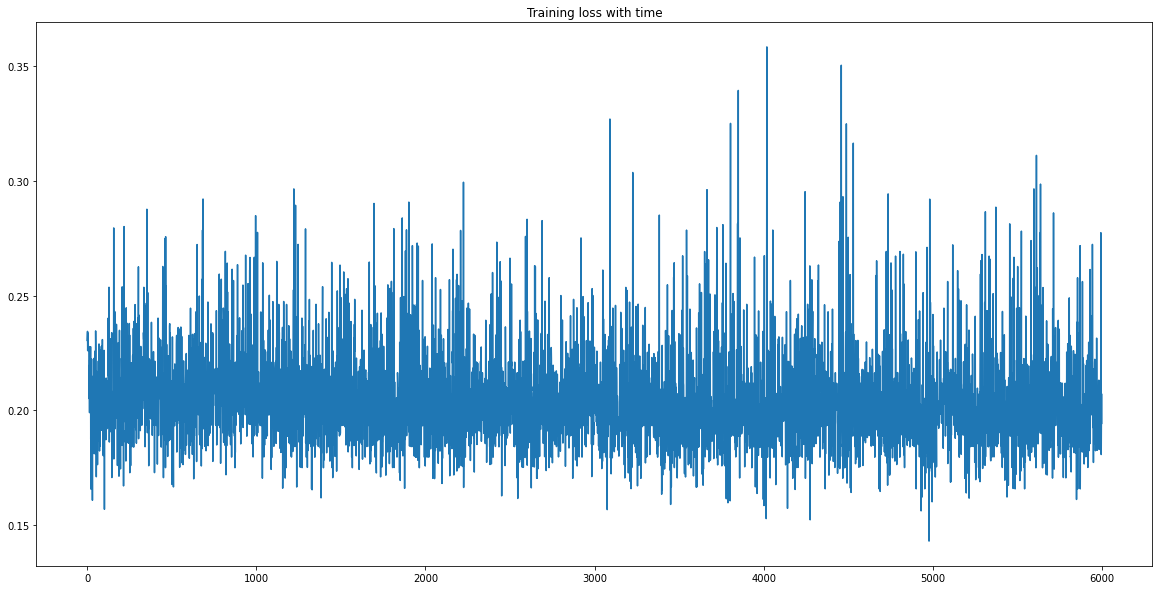

In [694]:
visualize_loss(losses2)

**Remaining Things to try**

- batch Norm
- adam
- testing the model